<a href="https://colab.research.google.com/github/AliJaffery12/Ball-Trajectory-Simulation-kalman-and-Particle-Filter-Sensor-Fusion/blob/main/Particle_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize Step
# Initialize the particles with random gaussian values around the initial conditions of the ball.
# The initial conditions are the mean of the gaussian and the standard deviation is the standard deviation of the noise.
def initialize_particles(N, x0, y0_height, v0_speed, theta_0_angle, initial_noise):
    particles = np.empty((N, 4))
    particles[:, 0] = x0 + np.random.normal(0, initial_noise, size=N)  # x
    particles[:, 1] = y0_height + np.random.normal(0, initial_noise, size=N)  # y
    particles[:, 2] = v0_speed * np.cos(np.deg2rad(theta_0_angle))
    particles[:, 3] = v0_speed * np.sin(np.deg2rad(theta_0_angle))
    return particles


# 2. Predict Step
# Move the particles according to the projectile motion model with noise added
#  to the x and y position to account for the uncertainty in the model.
# The noise is sampled from a gaussian distribution with mean 0 and standard deviation equal to the standard deviation of the noise.

def move_particles(particles, delta_t, g, x_noise, y_noise, N):
    # Update x and y position
    particles[:, 0] += particles[:, 2] * delta_t + np.random.normal(0, x_noise, size=N)
    particles[:, 1] += particles[:, 3] * delta_t - 0.5 * g * delta_t**2 + np.random.normal(0, y_noise, size=N)
    # Update velocity
    particles[:, 2] += 0
    particles[:, 3] += -g * delta_t
    return particles


# 3. Update Step
# Update the weights of each particle based on the difference between the predicted and measured position
# to see how well the particle matches the measurement.
# The weights are normalized so that they sum to 1.
# The weights are used to determine which particles to keep and which to discard.
# The particles with the highest weights are the ones that best match the measurement.

def update_weights(particles, weights, z , z_noise, N):
    for i in range(N):
        # Calculate the distance between the particle and the measurement
        distance = np.sqrt((particles[i, 0] - z[0])**2 + (particles[i, 1] - z[1])**2)
        # or
        #distance = np.linalg.norm(particles[i, :2] - z)
        # Calculate the weight using a Gaussian likelihood function
        weights[i] = (1/np.sqrt(2*np.pi*z_noise**2))*np.exp(-(distance**2)/(2*z_noise**2))
    #avoid round-off to zero
    weights += 1.e-300
    weights /= sum(weights)  # normalize the weights
    return weights

# 4. Resample Step
# Resample the particles based on their weights.
# The particles with the highest weights are the ones that best match the measurement.
# We want to keep these particles and discard the ones with the lowest weights.
# We will use the resampling wheel method to resample the particles.
# Resample the particles based on their weights using cumsum and np.searchsorted
#
def resample_particles_using_cumsum(particles, weights):
    particles_resampled = np.zeros_like(particles)
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.random(N))

    # resample according to indexes
    particles_resampled[:] = particles[indexes]
    weights.fill(1.0/N)
    return particles_resampled
# or using np.random.choice
def resample_particles(particles, weights):
    particles_resampled = np.zeros_like(particles)
    N = len(particles)
    # Draw N samples from the weights with replacement
    indices = np.random.choice(range(N), size=N, replace=True, p=weights)
    # Resample particles according to indices
    particles_resampled[:] = particles[indices]
    return particles_resampled

# 5. Compute the Estimate
def estimate(particles, weights):
    # Compute the mean of the weighted particles
    pos = particles[:, :2]
    mean = np.average(pos, weights=weights, axis=0)
    return mean

# 6. Compute the Effective Sample Size
# If Neff falls below some threshold, we resample the particles to avoid degeneracy.
def effective_sample_size(weights):
    return 1. / np.sum(np.square(weights))

In [2]:
def simulate_measurements(t, x0, y0,v0 ,theta, g,noise_std_dev):
    # Convert theta from degrees to radians
    theta_rad = np.radians(theta)

    # Calculate the real x and y positions
    x_real = x0 + v0 * np.cos(theta_rad) * t
    y_real = y0 + v0 * np.sin(theta_rad) * t - 0.5 * g * t**2

    # Generate some Gaussian noise
    noise = np.random.normal(scale=noise_std_dev, size=x_real.shape)

    # Add noise to the measurements
    x_real_noisy = x_real + noise
    y_real_noisy = y_real + noise

    return x_real_noisy, y_real_noisy

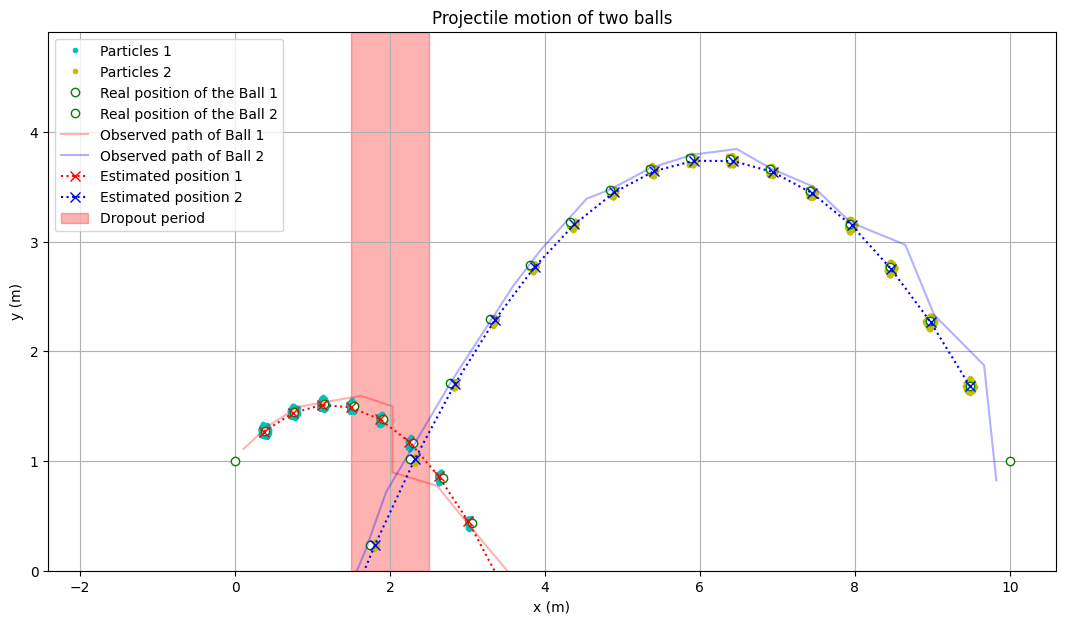

In [3]:
# Run the particle filter for throwing 2 balls simultaneously

# Define the launch variables
N = 500
x0, y0_height, v0_speed, theta_0_angle = 0, 1, 5, 40
x1, y1_height, v1_speed, theta_1_angle = 10, 1, 9, 125
g= 9.81
# Define the measurement noise
z_noise = 0.1
z_noise_1 = 0.18
# Define the process noise
x_noise = 0.001
y_noise = 0.003
#Initial conditions noise
initial_noise = 0.02
initial_noise_1 = 0.02
delta_t = 0.1

failure_start = 15  # Start of failure period (in time steps)
failure_duration = 10 # Duration of failure period (in time steps)


# Calculate the total time of flight
time_flight = (3*v1_speed*np.sin(np.deg2rad(theta_1_angle)))/g
# Time points at which we want measurements
t = np.arange(0.0,time_flight, delta_t)
# Generate noisy measurements
x_observed_1, y_observed_1 = simulate_measurements(t,x0 , y0_height,v0_speed, theta_0_angle, g, z_noise)
x_observed_2, y_observed_2 = simulate_measurements(t,x1,  y1_height,v1_speed, theta_1_angle, g, z_noise_1)

# Initialize particles for two balls
particles_one = initialize_particles(N, x0, y0_height, v0_speed, theta_0_angle, initial_noise)
particles_two = initialize_particles(N, x1, y1_height, v1_speed, theta_1_angle, initial_noise_1)

# Initialize uniform weights for two balls
weights_one = np.ones(N) / N
weights_two = np.ones(N) / N

# Initialize estimates
estimates_one = []
estimates_two = []

particles_one_list = []
particles_two_list = []

# Update for each timestep
for i in range(len(x_observed_1)):
    # Get measurements for both balls at this timestep
    z1 = np.array([x_observed_1[i], y_observed_1[i]])
    z2 = np.array([x_observed_2[i], y_observed_2[i]])

    # Move particles for both balls
    particles_one = move_particles(particles_one, delta_t, g, x_noise, y_noise,N)
    particles_two = move_particles(particles_two, delta_t, g, x_noise, y_noise, N)
    # copy to plot them later
    particles_one_list.append(particles_one.copy())
    particles_two_list.append(particles_two.copy())

    # Skip updating the weights during the failure period
    if not (failure_start <= i < failure_start + failure_duration):
        # Update weights based on measurement
        weights_one = update_weights(particles_one, weights_one, z1, z_noise,N)
        weights_two = update_weights(particles_two, weights_two, z2, z_noise_1,N)

    # Update weights based on measurement
    #weights_one = update_weights(particles_one, weights_one, z1, z_noise,N)
    #weights_two = update_weights(particles_two, weights_two, z2, z_noise,N)


    if effective_sample_size(weights_one) < N/0.5:
        #print('Resampling particles for ball 1')
        # Resample particles based on weights
        particles_one = resample_particles(particles_one, weights_one)
    if effective_sample_size(weights_two) < N/0.5:
        #print('Resampling particles for ball 2')
        # Resample particles based on weights
        particles_two = resample_particles(particles_two, weights_two)

    #particles_one = resample_particles(particles_one, weights_one)
    #particles_two = resample_particles(particles_two, weights_two)

    # Compute the estimates
    estimate_one = estimate(particles_one, weights_one)
    estimate_two = estimate(particles_two, weights_two)

    # Store estimates
    estimates_one.append(estimate_one)
    estimates_two.append(estimate_two)

# Convert estimates to arrays for easier slicing
estimates_one = np.array(estimates_one)
estimates_two = np.array(estimates_two)

# Calculate the x and y coordinates
x_real_1 = x0 + v0_speed*np.cos(np.deg2rad(theta_0_angle))*t
y_real_1 = y0_height + v0_speed*np.sin(np.deg2rad(theta_0_angle))*t - 0.5*g*t**2

x_real_2 = x1 + v1_speed*np.cos(np.deg2rad(theta_1_angle))*t
y_real_2 = y1_height + v1_speed*np.sin(np.deg2rad(theta_1_angle))*t - 0.5*g*t**2

failure_start_time = failure_start * delta_t
failure_end_time = (failure_start + failure_duration) * delta_t


# Plot the trajectory of the two balls
plt.figure(figsize=(13, 7))
for i in range(len(x_observed_1)):
    if i == 0:
        plt.plot(particles_one_list[i][:, 0], particles_one_list[i][:, 1], '.',color = 'c', label='Particles 1')
        plt.plot(particles_two_list[i][:, 0], particles_two_list[i][:, 1], '.',color ='y', label='Particles 2')
    else:         # Do not label the rest
        plt.plot(particles_one_list[i][:, 0], particles_one_list[i][:, 1], '.',color = 'c')
        plt.plot(particles_two_list[i][:, 0], particles_two_list[i][:, 1], '.', color ='y')
plt.plot(x_real_1, y_real_1, 'o', mec = 'g', mfc ='w', label='Real position of the Ball 1')
plt.plot(x_real_2, y_real_2, 'o', mec = 'g', mfc ='w', label='Real position of the Ball 2')
plt.plot(x_observed_1, y_observed_1, 'r', label='Observed path of Ball 1',  alpha= 0.3)
plt.plot(x_observed_2, y_observed_2, 'b', label='Observed path of Ball 2',  alpha= 0.3)
plt.plot(estimates_one[:, 0], estimates_one[:, 1], 'x:r', ms =7, label='Estimated position 1')
plt.plot(estimates_two[:, 0], estimates_two[:, 1], 'x:b',ms = 7, label='Estimated position 2')

plt.axvspan(failure_start_time,failure_end_time, color='red', alpha=0.3, label='Dropout period')

plt.title('Projectile motion of two balls')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid(True)
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [4]:
def particle_filter(N, launch_vars_one, launch_vars_two, g, noise_vars, time_flight):
    delta_t = noise_vars[3]
    t = np.arange(0.0,time_flight, delta_t)

    # Generate noisy measurements
    x_real1, y_real1 = simulate_measurements(t, *launch_vars_one, g, noise_std_dev=noise_vars[0])
    x_real2, y_real2 = simulate_measurements(t, *launch_vars_two, g, noise_std_dev=noise_vars[0])


    # Initialize particles for two balls
    particles_one = initialize_particles(N, *launch_vars_one, noise_vars[4])
    particles_two = initialize_particles(N, *launch_vars_two, noise_vars[4])

    # Initialize uniform weights for two balls
    weights_one = np.ones(N) / N
    weights_two = np.ones(N) / N

    # Initialize estimates
    estimates_one = []
    estimates_two = []

    # Update for each timestep
    for i in range(len(x_real1)):
        # Get measurements for both balls at this timestep
        z1 = np.array([x_real1[i], y_real1[i]])
        z2 = np.array([x_real2[i], y_real2[i]])

        # Move particles for both balls
        particles_one = move_particles(particles_one, delta_t, g, noise_vars[1], noise_vars[2], N)
        particles_two = move_particles(particles_two, delta_t, g, noise_vars[1], noise_vars[2], N)

        # Update weights based on measurement
        weights_one = update_weights(particles_one, weights_one, z1, noise_vars[0], N)
        weights_two = update_weights(particles_two, weights_two, z2, noise_vars[0], N)

        # Resample particles based on weights
        particles_one = resample_particles(particles_one, weights_one)
        particles_two = resample_particles(particles_two, weights_two)

        # Compute the estimates
        estimate_one = estimate(particles_one, weights_one)
        estimate_two = estimate(particles_two, weights_two)

        # Store estimates
        estimates_one.append(estimate_one)
        estimates_two.append(estimate_two)

    # Convert estimates to arrays for easier slicing
    estimates_one = np.array(estimates_one)
    estimates_two = np.array(estimates_two)

    return (x_real1, y_real1, estimates_one), (x_real2, y_real2, estimates_two)

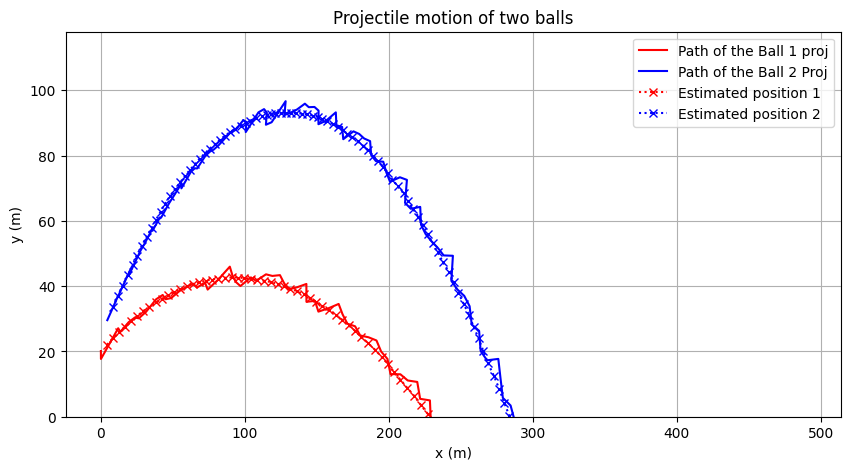

In [5]:
N = 500
g = 9.81
launch_vars_one = [0, 20, 50, 25]  # x0_shifted, y0, v0, theta_0
launch_vars_two = [5, 30, 50, 45]  # x1_shifted, y1, v1, theta_1
noise_vars = [1.5, 0.3, 0.05, 0.1, 0.01]  # z_noise, x_noise, y_noise, delta_t, initial_noise
time_flight = (3*launch_vars_two[2]*np.sin(np.deg2rad(launch_vars_two[3])))/g

# Run the particle filter
(x_observed_1, y_observed_1, ball_one_est), (x_observed_2, y_observed_2, ball_two_est) = particle_filter(N, launch_vars_one, launch_vars_two,g, noise_vars, time_flight)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_observed_1, y_observed_1, 'r', label='Path of the Ball 1 proj')
plt.plot(x_observed_2, y_observed_2, 'b', label='Path of the Ball 2 Proj')
plt.plot(ball_one_est[:, 0], ball_one_est[:, 1], 'x:r', label='Estimated position 1')
plt.plot(ball_two_est[:, 0], ball_two_est[:, 1], 'x:b', label='Estimated position 2')
plt.title('Projectile motion of two balls')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid(True)
plt.ylim(bottom=0)
plt.legend()
plt.show()